Домашнее задание № 3

In [108]:
import numpy as np
import pandas as pd

import scipy
from scipy import stats
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

Датасет представляет собой информацию по жителям некоторого города.

* `was_married` - Был ли когда-либо женат/замужем
* `children` - Количество детей
* `salary` - Уровень зарплаты
* `sex` - Пол (0 - женщина, 1 - мужчина)
* `age` - Возраст
* `home_cost` - Сумарная стоимость жилья/недвижимости
* `Professon` - Профессия
* `drive_info` - Есть ли водительские права
* `happyness` - уровень счастья по результатам опроса

Изучить датасет и, используя класстерный анализ, разбить пользователей на сегменты.
Сделать выводы о причинах такой кластеризации.

In [109]:
df = pd.read_csv(r'data/people_data_clustering_2.csv', index_col=0)
print("Размеры датасета", df.shape)
df.head()

Размеры датасета (6000, 9)


,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
id,,,,,,,,,
0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579


1. Очистка датасета


* Есть ли дубли в данных? Если есть удалить.
* Найти и удалить выбросы по признаку `home_cost`. (Их не больше 15-х, не меньше 3-х)

Проверяем дубли и удаляем

In [110]:
print(f'Duplicates: {df.shape[0] - df.drop_duplicates().shape[0]}')
df = df.drop_duplicates()

Duplicates: 0


Находим и удаляем выбросы в home_cost

Воспользуемся гистограммой и коробчатой диаграммой

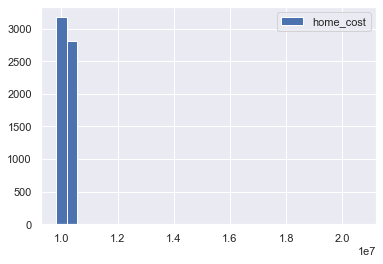

In [111]:
df['home_cost'].hist(bins=30, legend=True)
plt.show()

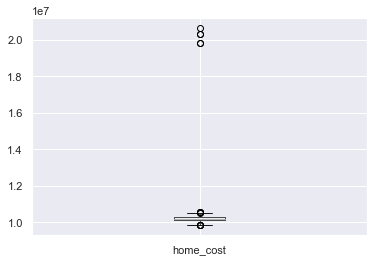

In [112]:
df.boxplot(column=['home_cost'])
plt.show()

<AxesSubplot:>

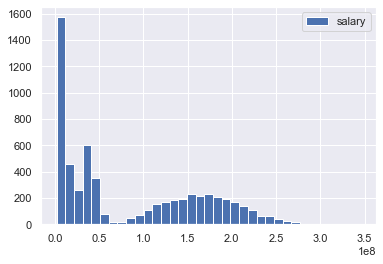

In [113]:
df['salary'].hist(bins=35, legend=True)

Исходя из диграмм, выбросы имеются и очень большие

Ограничим данные сверху и снизу квантилями

In [114]:
quantile_up = np.quantile(df['home_cost'], 0.9985)
quantile_down = np.quantile(df['home_cost'], 0.0015)
print(f'quantile up: {quantile_up}')
print(f'quantile down: {quantile_down}')

quantile up: 10522132.883081105
quantile down: 9868506.475295853


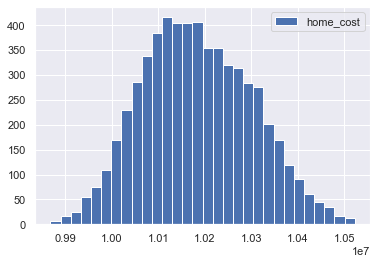

In [115]:
df_hc = df[(quantile_down < df['home_cost']) & (df['home_cost'] < quantile_up)]
df_hc['home_cost'].hist(bins=30, legend=True)
plt.show()

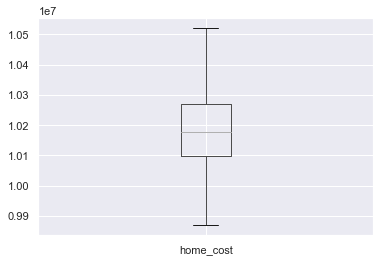

In [116]:
df_hc.boxplot(column='home_cost')
plt.show()

После выброса отклоняющихся значений гистограмма и коробчатая диаграмма имеют вид похожий на нормальное распределение

Проверка гипотез

* Проверить предложенные утверждения визуально.
* Применить подходящий статистический критерий, чтобы окончательно доказать или опровергнуть гипотезы на снове этих данных.

Правда ли женщины в среднем имеют более высокую зарплату, чем мужчины?

In [117]:
# оценим в лоб

# delete nan
dr_nan = df_hc.copy()
dr_nan.dropna(axis=0, subset=['sex', 'salary'], how='all', inplace=True)

# посчитаем среднее зп для обоих полов
female = dr_nan['sex'] == 0
male = dr_nan['sex'] == 1
female_salary = dr_nan[female]['salary']
male_salary = dr_nan[male]['salary']

female_salary_mean = female_salary.mean()
male_salary_mean = male_salary.mean()

print(f'Female mean salary: {round(female_salary_mean)}')
print(f'Man mean salary: {round(male_salary_mean)}')
print(f'Difference: {round(male_salary_mean / female_salary_mean, 2)}')

Female mean salary: 57847312
Man mean salary: 98445885
Difference: 1.7


<AxesSubplot:>

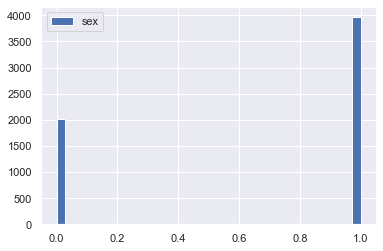

In [118]:
df_hc.sex.hist(bins=35, legend=True)
# sub = dr_nan[female | male]
# sns.displot(sub, x='sex', hue='salary', bins=15)
# plt.figure(figsize=(15, 8))
# sns.boxplot(data=sub, x='salary', y='sex')

Средняя зарплата женщин: 62975

А мужчин: 107195, что в 1.7 раза больше, так что визуально гипотеза кажется ошибочной

Применим статистический критерий

In [119]:
def get_stat(a, b):
    t, p_value = stats.ttest_ind(a, b)
    return t, p_value

In [123]:
cross = pd.crosstab(df_hc['sex'], df_hc['salary'])
chi, p_value, dof, exp = stats.chi2_contingency(female_salary, male_salary)
# print(pval)
# t, p_value  = get_stat(female_salary, male_salary)
print(f'P-value: {p_value}')

alpha = 0.05

print(p_value < alpha)

P-value: 1.0
False


P-value близкое к нулю, гипотезу отвергаем

Правда ли, что инженеры (Engineer) зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?

In [ ]:
# оценим в лоб

# delete nan
dr_nan.dropna(axis=0, subset=['profession', 'salary'], how='all', inplace=True)

# df_prf_slr = dr_nan[['profession', 'salary']]
# eng_salary = df_prf_slr.where(df_prf_slr['profession'] == 'Engineer')['salary']
eng_salary = df_hc[df_hc['profession'] == 'Engineer']['salary']
eng_salary_mean = eng_salary.mean()
ent_salary = df_hc[df_hc['profession'] == 'Entertainment']['salary']
ent_salary_mean = ent_salary.mean()

print(f'Engineer mean salary: {eng_salary_mean}')
print(f'Entertainment mean salary {ent_salary_mean}')
print(f'Difference: {round(ent_salary_mean / eng_salary_mean, 2)}')

In [ ]:
# оценим визуально
sub = df_hc[(df_hc['profession'] == 'Engineer') | (df_hc['profession'] == 'Entertainment')]
sns.displot(sub, x='salary', hue='profession', bins=35)

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=sub, x='profession', y='salary')

Средняя зарплата инженеров: 45272, а людей из сферы развлечений: 213996, что в 4.73 раза меньше. Печальная ситуация

Гипотеза неверна, пробуем статистический метод

In [ ]:
t, p_value  = stats.ttest_ind(eng_salary, ent_salary)
print(f'P-value: {p_value}')

alpha = 0.05

print(p_value < alpha)

P-value равен 0, значит можем смело отклонить гипотезу


Правда ли, что те, у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей?

In [ ]:
dr_nan.dropna(axis=0, subset=['childrens', 'salary'], how='all', inplace=True)

# оценим в лоб

large = dr_nan['childrens'] > 3
no_large = dr_nan['childrens'] < 3

large_salary = dr_nan[large]['salary']
no_large_salary = dr_nan[no_large]['salary']

print(f'Large salary mean: {large_salary.mean()}')
print(f'No large salary mean {no_large_salary.mean()}')
print(f'Difference: {round(large_salary.mean() / no_large_salary.mean(), 2)}')

In [ ]:
# оценим визуально

Простой подсчет среднего показывает, что для семей с детьми больше трех зп выше

Применим статистический критерий

In [ ]:
t, p_value = get_stat(no_large_salary, large_salary)

print(f'P-value: {p_value}')

alpha = 0.05

print(p_value < alpha)

Правда ли, что дома художники (Artist) живут в домах, которые в среднем дороже или дешевле, чем дома адвокатов (Lawyer)?

In [ ]:
dr_nan.dropna(axis=0, subset=['profession', 'home_cost'], how='all', inplace=True)

artist = dr_nan.profession == 'Artist'
lawyer = dr_nan.profession == 'Lawyer'

art_hc = dr_nan[artist].home_cost
law_hc = dr_nan[lawyer].home_cost

print(f'Artist mean home cost: {art_hc.mean()}')
print(f'Lawyer mean home cost: {law_hc.mean()}')

In [ ]:
sub = df_hc[artist | lawyer]
sns.displot(sub, x='home_cost', hue='profession', bins=35)

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=sub, x='profession', y='home_cost')

In [ ]:
t, p_value = get_stat(art_hc, law_hc)

print(f'P-value: {p_value}')

alpha = 0.05

print(p_value < alpha)

Правда ли, что недвижимость у бывавших в браке в среднем дороже, чем у не бывавших в браке?

In [ ]:
dr_nan.dropna(axis=0, subset=['was_married', 'home_cost'], how='all', inplace=True)

married = dr_nan.was_married == 1
no_married = dr_nan.was_married == 0

marr_hc = dr_nan[married].home_cost
nmarr_hc = dr_nan[no_married].home_cost

print(marr_hc.mean())
print(nmarr_hc.mean())

In [ ]:
sub = df_hc[married | no_married]
sns.displot(sub, x='home_cost', hue='was_married', bins=35)

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=sub, x='was_married', y='home_cost')

In [ ]:
cross = pd.crosstab(df_hc['was_married'], df_hc['home_cost'])
chi, p_value, dof, exp = stats.chi2_contingency(cross)
print(f'P-value: {p_value}')

alpha = 0.05

print(p_value < alpha)

Правда ли, что мужчины в среднем чаще бывают в браке, чем женщины?

In [ ]:
cross = pd.crosstab(df_hc['was_married'], df_hc['sex'])
chi, p_value, dof, exp = stats.chi2_contingency(cross)
print(f'P-value: {p_value}')

alpha = 0.05

print(p_value < alpha)

Гипотезы при множественном тестировании (10 баллов)

Правда ли между представителями таких профессий как, **Homemaker**, **Marketing**, **Healthcare** и **Executive** в среднем  зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием.

In [ ]:
homemaker_salary = df_hc[df_hc.profession == 'Homemaker']['salary']
marketing_salary = df_hc[df_hc.profession == 'Marketing']['salary']
health_salary = df_hc[df_hc.profession == 'Healthcare']['salary']
exec_salary = df_hc[df_hc.profession == 'Executive']['salary']


f_value, p_value = stats.f_oneway(homemaker_salary, marketing_salary, health_salary, exec_salary)
print(p_value)

In [ ]:
salary = homemaker_salary + marketing_salary + health_salary + exec_salary
profession = ['Homemaker'] * len(homemaker_salary) + ['Marketing'] * len(marketing_salary) + ['Healthcare'] * len(health_salary) + ['Executive'] * len(exec_salary)

df_mid = pd.DataFrame()
df_mid['salary'] = salary
df_mid['profession'] = profession

ax = sns.boxplot(x='profession', y='salary', data=df_mid)

plt.show()


Правда ли между представителями таких профессий как, **Doctor**, **Entertainment** и **Lawyer** в среднем  зарплаты не отличаются между собой?

In [ ]:
doc_salary = df_hc[df_hc.profession == 'Doctor']['salary']
law_salary = df_hc[df_hc.profession == 'Lawyer']['salary']

f_value, p_value = stats.f_oneway(doc_salary, ent_salary, law_salary)
print(p_value)

In [ ]:
salary = doc_salary + ent_salary + law_salary
profession = ['Doctor'] * len(doc_salary) + ['Entertainment'] * len(ent_salary) + ['Lawyer'] * len(law_salary)

df_mid = pd.DataFrame()
df_mid['salary'] = salary
df_mid['profession'] = profession

ax = sns.boxplot(x='profession', y='salary', data=df_mid)
#ax = sns.swarmplot(x="kinds", y="sizes", data=df_mid, color='#7d0013')
plt.show()

Регрессионный Анализ

Взглянем от чего зависит уровень счастья

Постройте регрессионную модель зависимости уровня счастья от приведенных факторов (was_married, children, salary, sex, age, home_cost)

In [125]:
factors = ('was_married', 'children', 'salary', 'sex', 'age', 'home_cost')
model = smf.ols(f'happyness ~ {" + ".join(factors)}', data=df_hc)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              happyness   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     939.6
Date:                Fri, 17 Dec 2021   Prob (F-statistic):               0.00
Time:                        22:59:39   Log-Likelihood:                 4698.2
No. Observations:                5982   AIC:                            -9382.
Df Residuals:                    5975   BIC:                            -9336.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0988      0.170      0.582      

Существует ли связь между уровнем счастья и зарплатой?

Насколько сильны эти отношения?

Ответ: coef = 2.1e-10 очень мал, связь очень слабая

Как факт брака способствуют стоимости недвижимости?

In [126]:
marr_hc_model = smf.ols('was_married ~ home_cost', data=df_hc)
result = marr_hc_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            was_married   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     780.7
Date:                Fri, 17 Dec 2021   Prob (F-statistic):          1.39e-161
Time:                        23:34:55   Log-Likelihood:                -2087.4
No. Observations:                5982   AIC:                             4179.
Df Residuals:                    5980   BIC:                             4192.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.5571      0.384     30.135      0.0

Факт брака слабо влияет на стоимость жилья (coef = -1.052e-06)